Date Created: 09/27/2024

Last Revised: 06/11/2025

Point of Contact: Abigayle Hodson, Abigayle_Hodson@lbl.gov

Organization: Lawrence Berkeley National Laboratory

Purpose: The purpose of this notebook is to estimate energy and water consumption of hoop houses, greenhouses, and plant factories for a variety of crops, technology levels, facility sizes, and climates in the United States. Carbon dioxide emissions associated with energy use are also estimated.













In [ ]:
#import necessary libraries and packages
import pandas as pd
import geopandas as gpd
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

#display all columns of dataframes
pd.set_option('display.max_columns', None)

#establish filepath for ease of file uploads
file_path = ''

Mounted at /content/gdrive/


#Define functions for estimating energy and water use

In [ ]:
def basic_setup(crop, facility_size, facility_type, tech_level, month, stacks = 4):
  '''
  Function that sets basic global variables for estimating energy/water footprint of CEA facilities based on crop, facility type/size, and technology level
    Parameters:
      crop = 'Roses', 'Lettuce', 'Spinach', 'Broccoli', 'Basil', 'Tomatoes', 'Bell peppers', 'Zucchini', or 'Strawberries'
      facility_size = 'Small' (<10,000 sq ft), 'Medium' (10,000-25,000 sq ft), or 'Large' (>25,000 sq ft)
      facility_type = 'Hoop House', 'Greenhouse', or 'Plant Factory'
      tech_level = 'Low-tech' or 'High-tech'
      month = month of the year (1 = 'January', 2 = 'February', etc.)
  '''
  #define variables as global
  global t_photo_hot, t_photo_cold, t_photo, dli_required, crop_temp_low_day, crop_temp_high_day, crop_temp_low_night, crop_temp_high_night, kc
  global num_stacks, w_l_ratio, floor_area, productive_area, length, width, height, growing_area, glazing_area, wall_area, roof_area, total_area
  global tau_sun, tau_pe, tau_pc, tau_pe, tau_pcc, tau_refraction_lens, tau_ww_strong, tau_ww_light, str_shade, photoperiod_light_lim, insulation, led_efficiency, led_efficiency_cooling, heating_efficiency, u, water_usage_rate

  #initialize static variables related to crop type, mainly temperature settings
  match crop:
    case 'Roses':
      t_photo = 16 #photoperiod (hours)
      dli_required = 20 #DLI (mol/m2/day)
      crop_temp_low_day = 18 #daytime low temperature (deg C)
      crop_temp_high_day = 24 #daytime high temperature (deg C)
      crop_temp_low_night = 15 #nighttime low temperature (deg C)
      crop_temp_high_night = 21 #nighttime high temperature (deg C)
      kc = 0.72 #crop coefficient
    case 'Lettuce':
      t_photo = 16 #photoperiod (hours)
      dli_required = 11.5 #DLI (mol/m2/day)
      crop_temp_low_day = 11.6 #daytime low temperature (deg C)
      crop_temp_high_day = 24.1 #daytime high temperature (deg C)
      crop_temp_low_night = 6 #nighttime low temperature (deg C)
      crop_temp_high_night = 14 #nighttime high temperature (deg C)
      kc = 1.00 #crop coefficient
    case 'Spinach':
      t_photo = 12 #photoperiod (hours)
      dli_required = 10.7 #DLI (mol/m2/day)
      crop_temp_low_day = 11 #daytime low temperature (deg C)
      crop_temp_high_day = 25 #daytime high temperature (deg C)
      crop_temp_low_night = 6 #nighttime low temperature (deg C)
      crop_temp_high_night = 14 #nighttime high temperature (deg C)
      kc = 1.00 #crop coefficient
    case 'Broccoli':
      t_photo = 12 #photoperiod (hours)
      dli_required = 12.4 #DLI (mol/m2/day)
      crop_temp_low_day = 10.5 #daytime low temperature (deg C)
      crop_temp_high_day = 21.2 #daytime high temperature (deg C)
      crop_temp_low_night = 4 #nighttime low temperature (deg C)
      crop_temp_high_night = 12 #nighttime high temperature (deg C)
      kc = 1.05 #crop coefficient
    case 'Basil':
      t_photo = 16 #photoperiod (hours)
      dli_required =  19 #DLI (mol/m2/day)
      crop_temp_low_day = 21 #daytime low temperature (deg C)
      crop_temp_high_day = 27 #daytime high temperature (deg C)
      crop_temp_low_night = 15 #nighttime low temperature (deg C)
      crop_temp_high_night = 18 #nighttime high temperature (deg C)
      kc =  0.86 #crop coefficient
    case 'Tomatoes':
      t_photo = 12 #photoperiod (hours)
      dli_required = 16 #DLI (mol/m2/day)
      crop_temp_low_day = 20.6 #daytime low temperature (deg C)
      crop_temp_high_day = 32.5 #daytime high temperature (deg C)
      crop_temp_low_night = 15 #nighttime low temperature (deg C)
      crop_temp_high_night = 23 #nighttime high temperature (deg C)
      kc = 1.15 #crop coefficient
    case 'Bell peppers':
      t_photo = 12 #photoperiod (hours)
      dli_required = 15 #DLI (mol/m2/day)
      crop_temp_low_day = 17.3 #daytime low temperature (deg C)
      crop_temp_high_day = 30 #daytime high temperature (deg C)
      crop_temp_low_night = 12 #nighttime low temperature (deg C)
      crop_temp_high_night = 20 #nighttime high temperature (deg C)
      kc = 1.05 #crop coefficient
    case 'Zucchini':
      t_photo = 16 #photoperiod (hours)
      dli_required = 10.8 #DLI (mol/m2/day)
      crop_temp_low_day = 11.3 #daytime low temperature (deg C)
      crop_temp_high_day = 24.6 #daytime high temperature (deg C)
      crop_temp_low_night = 6 #nighttime low temperature (deg C)
      crop_temp_high_night = 14 #nighttime high temperature (deg C)
      kc = 0.95 #crop coefficient
    case 'Strawberries':
      t_photo = 12 #photoperiod (hours)
      dli_required = 22.5 #DLI (mol/m2/day)
      crop_temp_low_day = 18 #daytime low temperature (deg C)
      crop_temp_high_day = 25 #daytime high temperature (deg C)
      crop_temp_low_night = 10 #nighttime low temperature (deg C)
      crop_temp_high_night = 12 #nighttime high temperature (deg C)
      kc = 0.86 #crop coefficient

  #initialize facility dimensions
  match facility_size:
    case 'Small':
      floor_area = 929.0304 #floor area (m2)
      width = (floor_area / 3) ** 0.5 #width of facility (m)
      length = floor_area / width #length of facility (m)
    case 'Medium':
      floor_area = 1625.8032 #floor area (m2)
      width = (floor_area / 3) ** 0.5 #width of facility (m)
      length = floor_area / width #length of facility (m)
    case 'Large':
      floor_area = 2322.576 #floor area (m2)
      width = (floor_area / 3) ** 0.5 #width of facility (m)
      length = floor_area / width #length of facility (m)
    case _:
      floor_area = facility_size #floor area (m2)
      width = (floor_area / 3) ** 0.5 #width of facility (m)
      length = floor_area / width #length of facility (m)

  #initialize building specifications
  match facility_type:
    case 'Hoop House':
      t_photo_hot = 7 #hottest photoperiod
      t_photo_cold = 19 #coldest photoperiod
      tau_pe = 0.85 #transmissivity of polyethylene (PE) (%)
      productive_area = 0.6 #productive area (%)
      growing_area = productive_area * length * width #growing area (m2)
      height = 4 #height of hoop house (m)
      wall_area = 2 * (length * height) + 2 * (width * height) #wall area (m2)
      roof_area = length * width #roof area (m2)
      total_area = wall_area + roof_area #total area (m2)
      glazing_area = total_area #total transparent surface area (m2)
      photoperiod_light_lim = 50 #photoperiod light limit (W/m2/C)
      str_shade = 0 #structural shading (%)
      insulation = (3.97 * glazing_area) / total_area #u-value (W/m2*K)
    case 'Greenhouse':
      t_photo_hot = 7 #hottest photoperiod
      t_photo_cold = 19 #coldest photoperiod
      led_efficiency = 0.59 #LED efficiency (%)
      tau_pe = 0.85 #transmissivity of polyethylene (PE) (%)
      tau_pc = 0.8 #transmissivity of polycarbonate (PC) (%)
      tau_pcc = 0.91 #transmissivity of corrugated polycarbonate (PCC) (%)
      str_shade = 0.05 #structural shading (%)
      tau_refraction_lens = 0.28 #transmissivity of refraction lens (%)
      tau_ww_strong = 0.5 #transmissivity of whitewash (strong) (%)
      tau_ww_light = 0.75 #transmissivity of whitewash (light) (%)
      productive_area = 0.82 #productive area (%)
      growing_area = productive_area * length * width #growing area (m2)
      height = 4 #height of greenhouse (m)
      wall_area = 2 * (length * height) + 2 * (width * height) #wall area (m2)
      roof_area = length * width #roof area (m2)
      total_area = wall_area + roof_area #total area (m2)
      glazing_area = total_area #total transparent surface area (m2)
      photoperiod_light_lim = 50 #photoperiod light limit (W/m2/C)
    case 'Plant Factory':
      t_photo_hot = 7 #hottest photoperiod
      t_photo_cold = 19 #coldest photoperiod
      led_efficiency = 0.59 #LED efficiency (%)
      led_efficiency_cooling = 0.85 #cooling efficiency of LEDs (%)
      tau_sun = 0 #solar transmissivity (%)
      str_shade = 1 #structural shading (%)
      height = 8 #height of plant factory (m)
      productive_area = 0.6 #productive area (%)
      num_stacks = stacks #number of stacks (default = 4)
      growing_area = stacks * productive_area * length * width #growing area (m2)
      glazing_area = 0 #total transparent surface area (m2)
      wall_area = 2 * (length * num_stacks * 1.5) + 2 * (width * num_stacks * 1.5) #wall area (m2)
      roof_area = length * width #roof area (m2)
      total_area = wall_area + roof_area #total area (m2)
      insulation = (3.9 * (total_area - glazing_area)) / total_area #u-value (W/m2*K)

  #set air flow rate based on technology level
  match tech_level:
    case 'Low-tech':
      u = 0.35 #average wind speed (m/s), assumed passive ventilation for low-tech greenhouses and hoop houses
    case 'High-tech':
      u = 0.6 #average wind speed (m/s); assumed between 0.5-0.7 m/s for high-tech greenhouses and plant factories
      if (facility_type == 'Greenhouse') & (month in [6,7,8,9]):
        u = 1 #average wind speed (m/s); high-tech greenhouses likely to increase air flow in the summer to control temperature

In [ ]:
def clean_met_data(location):
  '''
  Function that generates monthly average, maximum, and minimum temperature, relative humidity, and global horizontal irradiance (GHI) based on raw data from the National Solar radiation Database (NSRDB). Elevation data is also included for pressure calculations.
    Parameters:
      location = city name (e.g., Los Angeles, California)
    Returns:
      monthly_met = dataframe with average, maximum, and minimum temperature (deg C), relative humidity (%), and GHI (kWh/m2/d) (as well as elevation) per month for specified city
  '''
  #import meteorological data from NSRDB for specified city
  city_met = pd.read_csv(file_path + '/raw_data/meteorological_data/' + location + '.csv')

  #extract elevation (m) for water loss calculations
  elevation = city_met['Elevation'][0]

  #remove top two rows with metadata
  city_met.columns = city_met.iloc[1]
  city_met = city_met.iloc[2:city_met.shape[0]+1]
  city_met.reset_index(inplace = True, drop = True)

  #convert columns from strings to float
  city_met['Year'] = city_met['Year'].astype(float)
  city_met['Month'] = city_met['Month'].astype(int)
  city_met['GHI'] = city_met['GHI'].astype(float)
  city_met['Temperature'] = city_met['Temperature'].astype(float)
  city_met['Relative Humidity'] = city_met['Relative Humidity'].astype(float)

  #filter to 2022 meteorological data
  city_met = city_met.loc[city_met['Year'] == 2022]

  #initialize dataframe with monthly statistics
  monthly_met = pd.DataFrame()
  monthly_met['Month'] = [1,2,3,4,5,6,7,8,9,10,11,12]

  #group by month and calculate weather statistics
  monthly_met = city_met.groupby('Month').agg(
      GHI_mean=('GHI', lambda x: x.mean() * 24 / 1000),  #convert from W/m² to kWh/m²/d
      temp_mean=('Temperature', 'mean'),
      rh_mean=('Relative Humidity', 'mean'),
      temp_min=('Temperature', 'min'),
      temp_max=('Temperature', 'max'),
      rh_min=('Relative Humidity', 'min'),
      rh_max=('Relative Humidity', 'max')
  ).reset_index()

  #add elevation to monthly dataframe
  monthly_met['Elevation'] = elevation

  return monthly_met

In [ ]:
def calc_sun(lat, location, monthly_met):
  '''
  Function that calculates average sunlight hours, time of sunrise/sunset, unblocked daily light integral (DLI), and average sunlight for each hour of the day (Wh/m2/h) based on location
    Parameters:
      lat = latitude of city
      location = city name (e.g., Los Angeles, California)
      monthly_met = dataframe with average, maximum, and minimum temperature (deg C), relative humidity (%), and GHI (kWh/m2/d) per month for specified city
    Returns:
      monthly_sun = dataframe containing monthly temperature statistics, average sunlight hours (hrs/day), time of sunrise/sunset, unblocked DLI (mol/m2/day), and average sunlight for each hour of the day (Wh/m2/h)
  '''
  #initialize dataframe with monthly sunlight hours based on latitude
  monthly_sun = pd.DataFrame()
  monthly_sun['Month'] = [1,2,3,4,5,6,7,8,9,10,11,12]
  monthly_sun['sunlight_hrs'] = np.nan

  #calculate monthly sunlight hours based on latitude- polynomials are derived from (Weidner et al., 2021)
  monthly_sun.loc[monthly_sun['Month'] == 1, 'sunlight_hrs'] = ((-2*10**-5)*lat**3) - ((4*10**-5)*lat**2) - (0.0381*lat) + 12.043
  monthly_sun.loc[monthly_sun['Month'] == 2, 'sunlight_hrs'] = ((-8*10**-6)*lat**3) - ((3*10**-5)*lat**2) - (0.0262*lat) + 12.023
  monthly_sun.loc[monthly_sun['Month'] == 3, 'sunlight_hrs'] = ((-2*10**-6)*lat**3) - ((8*10**-6)*lat**2) - (0.0054*lat) + 12.006
  monthly_sun.loc[monthly_sun['Month'] == 4, 'sunlight_hrs'] = ((5*10**-6)*lat**3) + ((1*10**-5)*lat**2) + (0.0173*lat) + 11.988
  monthly_sun.loc[monthly_sun['Month'] == 5, 'sunlight_hrs'] = ((1*10**-5)*lat**3) + ((6*10**-5)*lat**2) + (0.0348*lat) + 11.955
  monthly_sun.loc[monthly_sun['Month'] == 6, 'sunlight_hrs'] = ((2*10**-5)*lat**3) + (0.0001*lat**2) + (0.0361*lat) + 11.924
  monthly_sun.loc[monthly_sun['Month'] == 7, 'sunlight_hrs'] = ((2*10**-5)*lat**3) + ((9*10**-5)*lat**2) + (0.0377*lat) + 11.953
  monthly_sun.loc[monthly_sun['Month'] == 8, 'sunlight_hrs'] = ((9*10**-6)*lat**3) + ((3*10**-5)*lat**2) + (0.0261*lat) + 11.973
  monthly_sun.loc[monthly_sun['Month'] == 9, 'sunlight_hrs'] = ((1*10**-6)*lat**3) + ((1*10**-6)*lat**2) + (0.0056*lat) + 11.998
  monthly_sun.loc[monthly_sun['Month'] == 10, 'sunlight_hrs'] = ((-6*10**-6)*lat**3) - ((2*10**-5)*lat**2) - (0.0167*lat) + 12.018
  monthly_sun.loc[monthly_sun['Month'] == 11, 'sunlight_hrs'] = ((-1*10**-5)*lat**3) - ((5*10**-5)*lat**2) - (0.0338*lat) + 12.043
  monthly_sun.loc[monthly_sun['Month'] == 12, 'sunlight_hrs'] = ((-2*10**-5)*lat**3) - (0.0001*lat**2) - (0.0361*lat) + 12.067

  #calculate sunrise and sunset based on sunlight hours
  monthly_sun['t_sunrise'] = 12.5 - monthly_sun['sunlight_hrs']/2
  monthly_sun['t_sunset'] = monthly_sun['t_sunrise'] + monthly_sun['sunlight_hrs']

  #merge with average monthly GHI (kWh/m2/day) per month
  monthly_sun = monthly_sun.merge(monthly_met, how = 'left', on = 'Month')

  #calculate maximum GHI (kW)
  monthly_sun['Max_GHI'] = 6*monthly_sun['GHI_mean']/monthly_sun['sunlight_hrs']/(3**0.5+2)

  #calculate photosynthetically active radiation (PAR) (mol/m2/day); note: ratio PAR to / Solar = 0.45 (J/J); Energy in PAR = 222,000 (J/mol)
  monthly_sun['DLI (PAR)'] = monthly_sun['GHI_mean']*3600*0.45/222000*1000

  #iterate through months of the year
  for index, row in monthly_sun.iterrows():
    #calculate average sunlight (Wh/m2/h) for each hour of the day
    for hour in range(24):
      if hour < row['t_sunset']:
        if hour < row['t_sunrise']:
          monthly_sun.at[index,'s_' + str(hour)] = 0
        else:
          monthly_sun.at[index,'s_' + str(hour)] = row['Max_GHI'] * 1000 * math.sin((hour - row['t_sunrise'])/row['sunlight_hrs'] * math.pi)
      else:
        monthly_sun.at[index,'s_' + str(hour)] = 0

  return monthly_sun

In [ ]:
def calc_temp(monthly_sun):
  '''
  Function that calculates 30-year average daily temperature and hourly temperature outside of facility based on monthly temperature and sunlight data.
    Parameters:
      monthly_sun = dataframe containing monthly temperature statistics, average sunlight hours (hrs/day), time of sunrise/sunset, unblocked DLI (mol/m2/day), and average sunlight for each hour of the day (Wh/m2/h)
    Returns:
      monthly_temp = 30-year average daily temperature and hourly temperature per month (deg C)
  '''
  #calculate monthly maximum change in temperature
  monthly_sun['delta_temp'] = monthly_sun['temp_max'] - monthly_sun['temp_min']

  #calculate hottest time of day; note, solar noon = 12.5 and percent lag = 0.33
  monthly_sun['t_hot'] = 12.5 + 0.33 * (monthly_sun['sunlight_hrs']/2)
  monthly_sun['t_24'] = monthly_sun['temp_max'] - monthly_sun['delta_temp']*(24 - monthly_sun['t_hot'])/(24 - (monthly_sun['t_hot'] - monthly_sun['t_sunrise']))

  #iterate through months of the year
  for index, row in monthly_sun.iterrows():
    #calculate 30-year average temperature for each hour of the day
    for hour in range(24):
      if hour < row['t_sunrise']:
        monthly_sun.at[index,'temp_' + str(hour)] = hour * (row['temp_min'] - row['t_24'])/row['t_sunrise'] + row['t_24']
      else:
        if hour < row['t_hot']:
          monthly_sun.at[index,'temp_' + str(hour)] = (hour - row['t_sunrise'])/(row['t_hot']- row['t_sunrise'])*row['delta_temp'] + row['temp_min']
        else:
          monthly_sun.at[index,'temp_' + str(hour)] = row['delta_temp']*(row['t_hot']-hour)/(24 -(row['t_hot']-row['t_sunrise'])) + row['temp_max']

  #calculate 30-year average daily temperature
  monthly_sun['temp_daily'] = monthly_sun[['temp_0', 'temp_1', 'temp_2', 'temp_3',
       'temp_4', 'temp_5', 'temp_6', 'temp_7', 'temp_8', 'temp_9', 'temp_10', 'temp_11', 'temp_12',
       'temp_13', 'temp_14', 'temp_15', 'temp_16', 'temp_17', 'temp_18', 'temp_19', 'temp_20', 'temp_21',
       'temp_22', 'temp_23']].mean(axis = 1)

  #filter to temperature parameters needed to infer cover material and estimate evapotranspiration
  monthly_temp = monthly_sun[['Month','delta_temp','t_hot','t_24','temp_0', 'temp_1', 'temp_2', 'temp_3',
       'temp_4', 'temp_5', 'temp_6', 'temp_7', 'temp_8', 'temp_9', 'temp_10', 'temp_11', 'temp_12',
       'temp_13', 'temp_14', 'temp_15', 'temp_16', 'temp_17', 'temp_18', 'temp_19', 'temp_20', 'temp_21',
       'temp_22', 'temp_23','temp_daily']]

  return monthly_temp

In [ ]:
def calc_rh(monthly_sun):
  '''
  Function that calculates 30-year average daily relative humidity and hourly relative humidity based on monthly relative humidity and sunlight data.
    Parameters:
      monthly_sun = dataframe containing monthly temperature and relative humidity statistics, as well as time of sunrise/sunset
    Returns:
      monthly_rh = 30-year average daily relative humidity and hourly relative humidity per month (%)
  '''
  #calculate monthly maximum change in relative humidity
  monthly_sun['delta_rh'] = monthly_sun['rh_min'] - monthly_sun['rh_max']

  #calculate t min; note percentage lag = 0.33
  monthly_sun['t_min'] = 12 + 0.33 * (monthly_sun['sunlight_hrs'] / 2)

  #calculate 24-hour relative humidity
  monthly_sun['rh_24'] = monthly_sun['rh_min'] - monthly_sun['delta_rh']*(24 - monthly_sun['t_min'])/(24 - (monthly_sun['t_min'] - monthly_sun['t_sunrise']))

  #iterate through months of the year
  for index, row in monthly_sun.iterrows():
    #calculate 30-year average relative humidity for each hour of the day
    for hour in range(24):
      if hour < row['t_sunrise']:
        monthly_sun.at[index, 'rh_' + str(int(hour))] = hour * (row['rh_max'] - row['rh_24'])/row['t_sunrise'] + row['rh_24']
      else:
        if hour < row['temp_min']:
          monthly_sun.at[index, 'rh_' + str(int(hour))] = (hour - row['t_sunrise'])/(row['t_min'] - row['t_sunrise']) * row['delta_rh'] + row['rh_max']
        else:
          monthly_sun.at[index, 'rh_' + str(int(hour))] = row['delta_rh'] * (row['t_min'] - hour)/(24 - (row['t_min'] - row['t_sunrise'])) + row['rh_min']

  #calculate 30-year average daily relative humidity
  monthly_sun['rh_daily'] = monthly_sun[['rh_0', 'rh_1', 'rh_2', 'rh_3',
       'rh_4', 'rh_5', 'rh_6', 'rh_7', 'rh_8', 'rh_9', 'rh_10', 'rh_11', 'rh_12',
       'rh_13', 'rh_14', 'rh_15', 'rh_16', 'rh_17', 'rh_18', 'rh_19', 'rh_20', 'rh_21',
       'rh_22', 'rh_23']].mean(axis = 1)

  #calculate saturation vapor pressure for each hour of the day (kPa)
  monthly_sun['Ps_Tmax'] = 0.611 * math.e**(17.27 * monthly_sun['temp_max']/(monthly_sun['temp_max'] + 237.3))
  monthly_sun['Ps_Tmin'] = 0.611 * math.e**(17.27 * monthly_sun['temp_min']/(monthly_sun['temp_min'] + 237.3))

  #calculate vapor pressure for each hour of the day (kPa)
  monthly_sun['Pw_Tmax'] = monthly_sun['Ps_Tmax'] * monthly_sun['rh_min']/100
  monthly_sun['Pw_Tmin'] = monthly_sun['Ps_Tmin'] * monthly_sun['rh_max']/100
  monthly_sun['Pw_average'] = (monthly_sun['Pw_Tmax'] + monthly_sun['Pw_Tmin'])/2

  #filter to relative humidity parameters needed for evapotranspiration calculations
  monthly_rh = monthly_sun[['Month','rh_min','rh_max','delta_rh','t_sunrise','sunlight_hrs','t_min','rh_24','rh_0', 'rh_1', 'rh_2', 'rh_3',
       'rh_4', 'rh_5', 'rh_6', 'rh_7', 'rh_8', 'rh_9', 'rh_10', 'rh_11', 'rh_12',
       'rh_13', 'rh_14', 'rh_15', 'rh_16', 'rh_17', 'rh_18', 'rh_19', 'rh_20', 'rh_21',
       'rh_22', 'rh_23','rh_daily','Pw_Tmax','Pw_Tmin','Pw_average']]

  return monthly_rh

In [ ]:
def LED_on(t_photo, facility_type):
  '''
  Function that determines if LEDs are turned on or off in plant factories for each hour of the day based on photoperiod of user-specified crop
    Parameters:
      t_photo = crop-specific photoperiod (hours)
    Returns:
      LED_on_off = dataframe that indicates which hours of the day LEDs are turned on (1 = on, 0 = off)
  '''
  #initialize dataframe that indicates which hours of the day LEDs are turned on
  LED_on_off = pd.DataFrame()
  LED_on_off['Hour'] = range(24)

  #check that facility uses LEDs
  if facility_type == 'Plant Factory':
    #depending on crop type, determine whether LED is on or off
    dark_start = math.ceil(t_photo/2)
    photo_start = 24 - dark_start
    for index, row in LED_on_off.iterrows():
      if (index < dark_start) | (index >= photo_start):
        LED_on_off.at[index,'LED_on'] = 1
      else:
        LED_on_off.at[index,'LED_on'] = 0

  return LED_on_off

In [ ]:
def calc_LED(monthly_sun):
  '''
  Function that calculates LED energy consumption based on facility location, type, and crop
    Parameters:
      monthly_sun = dataframe containing latitude-specific monthly temperature statistics, average sunlight hours (hrs/day), time of sunrise/sunset, unblocked DLI (mol/m2/day), and average sunlight for each hour of the day (Wh/m2/h)
    Returns:
      hourly_LED = dataframe containing hourly LED power requirements (Wh/m2) for given month
  '''
  #define variables as global
  global insulation

  #add column for crop type and crop-specific DLI requirements
  monthly_sun['Crop'] = crop
  monthly_sun['DLI required'] = dli_required

  #calculate power required for LEDs based on facility location, type, and crop type
  match facility_type:
    case 'Hoop House':
      #initialize dataframe for LED power requirements at each hour of the day for given month
      hourly_LED = pd.DataFrame()
      hourly_LED['Hour'] = range(24)
      hourly_LED['Total LED Electricity'] = 0

      #for each hour of the day, calculate solar radiation into hoop house (Wh/hr/m2)
      for index, row in hourly_LED.iterrows():
        s_curr = monthly_sun.loc[monthly_sun['Month'] == month, 's_' + str(int(row['Hour']))].values[0]
        hourly_LED.at[index, 'Solar radiation into facility'] = s_curr * tau_pe

      #calculate natural DLI to plant
      monthly_sun['Actual DLI on plant (PAR)'] = monthly_sun['DLI (PAR)'] * tau_pe * (1 - str_shade)
      hourly_LED['Actual DLI on plant (PAR)'] = monthly_sun.loc[monthly_sun['Month'] == month, 'Actual DLI on plant (PAR)'].values[0]

    case 'Greenhouse':
      #calculate 30-year average daily temperature
      monthly_temp = calc_temp(monthly_sun)

      #if one or more months have an average daily temperature below 0 degrees C or at least three months have an average daily temperature less than 7.5 deg C, assume closed greenhouse uses PE cover
      if (monthly_temp.loc[monthly_temp['temp_daily'] < 0].shape[0] > 0) | (monthly_temp.loc[monthly_temp['temp_daily'] < 7.5].shape[0] > 3):
        cover_type = 1 #1 = PE
        insulation = (3.97 * glazing_area) / total_area
        tau_overall = tau_pe
      #otherwise, assume PC cover
      else:
        cover_type = 0 #0 = PC
        insulation = (3.01 * glazing_area) / total_area
        tau_overall = tau_pc

      #assume PCC cover for high-tech greenhouses
      if tech_level == 'High-tech':
        insulation = (6.81 * glazing_area) / total_area
        tau_overall = tau_pcc

      #calculate natural DLI to plant based on cover type
      if cover_type == 1:
        monthly_sun['Actual DLI on plant (PAR)'] = monthly_sun['DLI (PAR)'] * tau_pe * (1 - str_shade)
      elif cover_type == 0:
        monthly_sun['Actual DLI on plant (PAR)'] = monthly_sun['DLI (PAR)'] * tau_pc * (1 - str_shade)
      elif tech_level == 'High-tech':
        monthly_sun['Actual DLI on plant (PAR)'] = monthly_sun['DLI (PAR)'] * tau_pcc * (1 - str_shade)

      #calculate additional DLI required from LEDs
      for index, row in monthly_sun.iterrows():
        if row['DLI required'] - row['Actual DLI on plant (PAR)'] > 0:
          monthly_sun.at[index, 'Additional DLI required'] = row['DLI required'] - row['Actual DLI on plant (PAR)']
        else:
          monthly_sun.at[index, 'Additional DLI required'] = 0

      #calculate percentage of required light for crop provided by the sun (%)
      monthly_sun['Natural DLI'] = monthly_sun['Actual DLI on plant (PAR)']/monthly_sun['DLI required']

      #determine whether refraction lens cover is favourable based on natural DLI
      for index, row in monthly_sun.iterrows():
        if row['Natural DLI'] > 1/(tau_refraction_lens/tau_overall/(1 - str_shade)):
          monthly_sun.at[index, 'Refraction lens cover hypothetically favourable?'] = 1
        else:
          monthly_sun.at[index, 'Refraction lens cover hypothetically favourable?'] = 0

      #determine if refraction lens cover should be installed and used for more than 3 months
      sum_rl = monthly_sun['Refraction lens cover hypothetically favourable?'].sum()
      for index, row in monthly_sun.iterrows():
        if sum_rl > 3:
          monthly_sun.at[index, 'Refraction lens cover installed and used (>3 months)?'] = row['Refraction lens cover hypothetically favourable?']
        else:
          monthly_sun.at[index, 'Refraction lens cover installed and used (>3 months)?'] = 0

      #infer strength of whitewash based on whether refraction lens cover is used
      for index, row in monthly_sun.iterrows():
        if row['Refraction lens cover installed and used (>3 months)?'] == 1:
          monthly_sun.at[index, 'Whitewash strong?'] = 0
        else:
          if row['Natural DLI'] > (1 / tau_ww_strong):
            monthly_sun.at[index, 'Whitewash strong?'] = 1
          else:
            monthly_sun.at[index, 'Whitewash strong?'] = 0

      for index, row in monthly_sun.iterrows():
        if (row['Refraction lens cover installed and used (>3 months)?'] == 1) | (row['Whitewash strong?'] == 1):
          monthly_sun.at[index, 'Whitewash light?'] = 0
        else:
          if row['Natural DLI'] > (1 / tau_ww_light):
            monthly_sun.at[index, 'Whitewash light?'] = 1
          else:
           monthly_sun.at[index, 'Whitewash light?'] = 0

      #initialize dataframe for LED power requirements at each hour of the day for given month
      hourly_LED = pd.DataFrame()
      hourly_LED['Hour'] = range(24)
      hourly_LED['Actual DLI on plant (PAR)'] = monthly_sun.loc[monthly_sun['Month'] == month, 'Actual DLI on plant (PAR)'].values[0]

      #for each hour of the day, calculate solar radiation into greenhouse (Wh/hr/m2) based on cover material, structural shading, and refraction lens
      for index, row in hourly_LED.iterrows():
        s_curr = monthly_sun.loc[monthly_sun['Month'] == month, 's_' + str(int(row['Hour']))].values[0]
        if monthly_sun.loc[monthly_sun['Month'] == month, 'Refraction lens cover installed and used (>3 months)?'].values[0] == 1:
          hourly_LED.at[index, 'Solar radiation into facility'] = s_curr * tau_refraction_lens
        else:
          if cover_type == 1:
            hourly_LED.at[index, 'Solar radiation into facility'] = s_curr * tau_pe * (1 - str_shade)
          elif cover_type == 0:
            hourly_LED.at[index, 'Solar radiation into facility'] = s_curr * tau_pc * (1 -  str_shade)
          elif tech_level == 'High-tech':
            hourly_LED.at[index, 'Solar radiation into facility'] = s_curr * tau_pcc * (1 -  str_shade)

      for index, row in hourly_LED.iterrows():
        if monthly_sun.loc[monthly_sun['Month'] == month, 'Whitewash strong?'].values[0] == 1:
          hourly_LED.at[index, 'Solar radiation into facility'] = row['Solar radiation into facility'] * tau_ww_strong
        else:
          if monthly_sun.loc[monthly_sun['Month'] == month, 'Whitewash light?'].values[0] == 1:
            hourly_LED.at[index, 'Solar radiation into facility'] = row['Solar radiation into facility'] * tau_ww_light
          else:
            hourly_LED.at[index, 'Solar radiation into facility'] = row['Solar radiation into facility']

      #calculate maximum solar PAR; note PAR within sunlight = 0.45 J/J
      max_solar_par = hourly_LED['Solar radiation into facility'].max() * 0.45

      #calculate integral solar PAR; note PAR within sunlight = 0.45 J/J
      integral_solar_par = hourly_LED['Solar radiation into facility'].sum() * 0.45

      #calculate LED PAR integral; note PAR conversion = 4.57 (umol/J); radiation plant bed = 79 (%)
      led_par_integral = monthly_sun.loc[monthly_sun['Month'] == month, 'Additional DLI required'].values[0] / (4.57 * 3600 / 1000000) / 0.79

      #calculate hourly sunshine above
      for index, row in hourly_LED.iterrows():
        if (max_solar_par < (integral_solar_par + led_par_integral)/12) | (row['Solar radiation into facility']*0.45 > (integral_solar_par + led_par_integral)/12):
          hourly_LED.at[index, 'sunshine_above'] = row['Solar radiation into facility'] * 0.45 - (integral_solar_par + led_par_integral)/12
        else:
         hourly_LED.at[index, 'sunshine_above'] = 0

      #calculate how many hours of the day have excess radiation
      t_excess_rad = hourly_LED.loc[hourly_LED['sunshine_above'] > 0].shape[0]

      #calculate new intensity
      new_intensity = (integral_solar_par + led_par_integral)/12 - hourly_LED['sunshine_above'].sum()/(12 - t_excess_rad)

      #calculate how much PAR is required from LEDs (Wh/hr/m2)
      for index, row in hourly_LED.iterrows():
        if (index < t_photo_hot) | (index >= t_photo_cold) | (led_par_integral == 0):
          hourly_LED.at[index, 'LED PAR'] = 0
        else:
          if max_solar_par < (integral_solar_par + led_par_integral)/12:
            hourly_LED.at[index, 'LED PAR'] = (integral_solar_par + led_par_integral)/12 - row['Solar radiation into facility'] * 0.45
          else:
            if new_intensity - row['Solar radiation into facility'] * 0.45 < 0:
              hourly_LED.at[index, 'LED PAR'] = 0
            else:
              hourly_LED.at[index, 'LED PAR'] = new_intensity - row['Solar radiation into facility'] * 0.45

      #calculate power required by LEDS (Wh/m2)
      hourly_LED['LED Power'] = hourly_LED['LED PAR'] / led_efficiency

      #add column for share of LED waste heat cooled by water for each hour of the day (%)
      hourly_LED['Share of LED waste heat water cooled'] = 0.5
      hourly_LED.loc[hourly_LED['Hour']  == 5, 'Share of LED waste heat water cooled'] = 0.53

      #calculate waste heat from LEDs (kW)
      hourly_LED['LED Waste Heat'] = (hourly_LED['LED Power'] - hourly_LED['LED PAR']) * hourly_LED['Share of LED waste heat water cooled'] * growing_area / 1000

      for index, row in hourly_LED.iterrows():
        #calculate temperature outside of the facility (deg C)
        hourly_LED.at[index, 'temp_outside'] = monthly_temp.loc[monthly_temp['Month'] == month, 'temp_' + str(int(row['Hour']))].values[0]

      for index, row in hourly_LED.iterrows():
        #calculate coefficient of performance for cooling LEDs based on temperature outside of facility
        if 25.067 * math.e**(-0.05 * row['temp_outside']) > 20:
          hourly_LED.at[index, 'COP Cool LED'] = 20
        else:
          hourly_LED.at[index, 'COP Cool LED'] = 25.067 * math.e**(-0.05 * row['temp_outside'])

      #calculate power required to cool LEDs (Wh/m2)
      hourly_LED['LED Cooling'] = (hourly_LED['LED Waste Heat'] / hourly_LED['COP Cool LED']) / growing_area * 1000

      #calculate total electricity required for LEDs, including cooling (Wh/m2)
      hourly_LED['Total LED Electricity'] = hourly_LED['LED Power'] + hourly_LED['LED Cooling']

      #assume no LEDs are used for low-tech greenhouses and hoophouses
      if tech_level == 'Low-tech':
        hourly_LED['Total LED Electricity'] = 0

    case 'Plant Factory':
      #calculate additional required DLI for crop
      monthly_sun['Actual DLI on plant (PAR)'] = monthly_sun['DLI (PAR)'] * tau_sun * (1-str_shade)
      for index, row in monthly_sun.iterrows():
        if row['DLI required'] - row['Actual DLI on plant (PAR)'] > 0:
          monthly_sun.at[index,'Additional DLI required'] = row['DLI required'] - row['Actual DLI on plant (PAR)']
        else:
          monthly_sun.at[index,'Additional DLI required'] = 0

      #calculate what hours of the day LEDs are turned on
      LED_on_off = LED_on(t_photo, facility_type)

      #for given month, initialize dataframe of LED power requirements at each hour of the day
      hourly_LED = pd.DataFrame()
      hourly_LED['Hour'] = range(24)
      hourly_LED = hourly_LED.merge(LED_on_off, how = 'left', on = 'Hour')
      hourly_LED['Additional DLI required'] = monthly_sun.loc[monthly_sun['Month'] == month, 'Additional DLI required'].values[0]
      hourly_LED['Actual DLI on plant (PAR)'] = monthly_sun.loc[monthly_sun['Month'] == month, 'Actual DLI on plant (PAR)'].values[0]
      hourly_LED['Solar radiation into facility'] = 0

      #calculate power required by LEDs (Wh/m2); note, radiation plant bed = 89%, PAR conversion = 4.57 umol/W
      hourly_LED['LED Power'] = hourly_LED['LED_on'] * hourly_LED['Additional DLI required'] / t_photo / 0.89 / (4.57 * 3600 / 1000000) / led_efficiency

      #calculate waste heat from LEDs (kW)
      hourly_LED['LED Waste Heat'] = (hourly_LED['LED Power'] - hourly_LED['LED Power']*led_efficiency) * growing_area / 1000 * led_efficiency_cooling

      #estimate average temperature at each hour of the day for given month
      monthly_temp = calc_temp(monthly_sun)
      for index, row in hourly_LED.iterrows():
        hourly_LED.at[index, 'temp_outside'] = monthly_temp.loc[monthly_temp['Month'] == month, 'temp_' + str(int(row['Hour']))].values[0]

      for index, row in hourly_LED.iterrows():
        #calculate coefficient of performance for cooling LEDs
        if 25.067 * math.e**(-0.05 * row['temp_outside']) > 20:
          hourly_LED.at[index, 'COP Cool LED'] = 20
        else:
          hourly_LED.at[index, 'COP Cool LED'] = 25.067 * math.e**(-0.05 * row['temp_outside'])

      #calculate power required to cool LEDs (Wh/m2)
      hourly_LED['LED Cooling'] = (hourly_LED['LED Waste Heat'] / hourly_LED['COP Cool LED']) / growing_area * 1000

      #calculate total electricity required for LEDs, including cooling (Wh/m2)
      hourly_LED['Total LED Electricity'] = hourly_LED['LED Power'] + hourly_LED['LED Cooling']

  return hourly_LED

In [ ]:
def calc_ET(hourly_LED, monthly_sun):
  '''
  Function that calculates evapotranspiration (mm/h) based on facility location, type, and crop.
    Parameters:
      hourly_LED = dataframe containing hourly solar radiation for given month
      monthly_sun = dataframe containing latitude-specific monthly temperature statistics and elevation of location (m)
    Returns:
      hourly_ET = dataframe with hourly evapotranspiration (mm/h)
  '''
  #for given month, initialize dataframe of evapotranspiration at each hour of the day
  hourly_ET = pd.DataFrame()
  hourly_ET['Hour'] = range(24)

  if facility_type == 'Hoop House':
    #pull solar radiation entering hoophouse from LED calculations
    hourly_ET['Solar radiation into facility'] = hourly_LED['Solar radiation into facility']

    #determine which hours of the day are within photoperiod for specified crop
    for index, row in hourly_ET.iterrows():
      if (row['Solar radiation into facility'] < photoperiod_light_lim) & ((index < t_photo_hot) | (index >= t_photo_cold)):
        hourly_ET.at[index, 'photoperiod'] = 0
      else:
        hourly_ET.at[index, 'photoperiod'] = 1

    #calculate maximum and minimum temperature setting bounds based on crop and time of day
      if hourly_ET.at[index, 'photoperiod'] == 0:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_night
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_night
      else:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_day
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_day

    #depending on climate zone, set the hourly mean temperature in the hoop house (deg C), assuming that temperature within hoop house stays within tolerable range for selected crop
    for index, row in hourly_ET.iterrows():
      if ('Hot' in climate_zone):
        hourly_ET['temp_avg'] = hourly_ET['temp_set_high']
      elif ('Cold' in climate_zone) or ('Subarctic' in climate_zone):
        hourly_ET['temp_avg'] = hourly_ET['temp_set_low']
      else:
        hourly_ET['temp_avg'] = (hourly_ET['temp_set_low'] + hourly_ET['temp_set_high'])/2

    #calculate average temperature outside of hoop house at each hour of the day for given month
    monthly_temp = calc_temp(monthly_sun)

    #calculate hourly relative humidity set point based on photoperiod and average temperature outside of the hoop house
    for index, row in hourly_ET.iterrows():
      if hourly_ET.at[index, 'photoperiod'] == 0:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 12:
          hourly_ET.at[index, 'rh_set'] = 65
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 20:
            hourly_ET.at[index, 'rh_set'] = 80
          else:
            hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 12)/(20 - 12)*(80 - 65) + 65
      else:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 20:
          hourly_ET.at[index, 'rh_set'] = 75
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 28:
              hourly_ET.at[index, 'rh_set'] = 85
          else:
              hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 20)/(28 - 20) * (85 - 75) + 75

      hourly_ET.at[index, 'rh_set'] = hourly_ET.at[index, 'rh_set']/100

    #calculate hourly saturation vapor pressure (es) (kPa)
    hourly_ET['es'] = 0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg']) / (hourly_ET['temp_avg'] + 273.3))

    #calculate hourly actual vapor pressure (ea) (kPa) based on relative humidity settings- assumes that relative humidity in the hoop house is kept equal to the setpoint through passive ventilation
    hourly_ET['ea'] = hourly_ET['es'] * hourly_ET['rh_set']

    #calculate hourly vapor pressure deficit (kPA) based on saturation and actual vapor presssure
    hourly_ET['VPD'] = hourly_ET['es'] - hourly_ET['ea']

    #calculate net radiation at plant surface (Rn) (MJ/m2*hr) by converting DLI (mol/m2*day); note, 222,000 J/mol = energy in PAR
    hourly_ET['Rn'] = hourly_LED['Actual DLI on plant (PAR)'] * 222000 / 10**6 / 24

    #calculate atmospheric pressure (kPa) based on facility elevation
    pressure_atm = 101.3 * ((293 - 0.0065 * monthly_sun['Elevation'][0])/293)**5.26

    #calcuate pyschometric constant (kPa / deg C) based on atmospheric pressure
    hourly_ET['gamma'] = (0.001005 * pressure_atm) / (2.45 * 0.622)

    #calculate saturation slope vapor pressure curve at temp_avg (kPa / deg C)
    hourly_ET['delta'] = (4098 * (0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg'])/(hourly_ET['temp_avg'] + 237.3)))) / (hourly_ET['temp_avg'] + 237.3)**2

    #calculate evapotranspiration in greenhouse (mm/hour) using the FAO Penman-Monteith equation; assume soil heat flux = 0
    hourly_ET['ET'] = kc * (0.408 * hourly_ET['delta'] * hourly_ET['Rn'] + hourly_ET['gamma'] * (37 / (hourly_ET['temp_avg'] + 273)) * u * hourly_ET['VPD']) / (hourly_ET['delta'] + hourly_ET['gamma'] * (1 + 0.34 * u))

  elif facility_type == 'Greenhouse':
    #pull solar radiation from LED calculations
    hourly_ET['Solar radiation into facility'] = hourly_LED['Solar radiation into facility']

    #determine which hours of the day are within photoperiod for specified crop
    for index, row in hourly_ET.iterrows():
      if (row['Solar radiation into facility'] < photoperiod_light_lim) & ((index < t_photo_hot) | (index >= t_photo_cold)):
        hourly_ET.at[index, 'photoperiod'] = 0
      else:
        hourly_ET.at[index, 'photoperiod'] = 1

    #calculate temperature setting bounds based on crop and time of day
    for index, row in hourly_ET.iterrows():
      if hourly_ET.at[index, 'photoperiod'] == 0:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_night
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_night
      else:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_day
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_day

    #depending on climate zone, set the hourly mean temperature in the facility (deg C)- this simplification allows us to bypass the HVAC calculations
    if ('Hot' in climate_zone) or ('Mixed' in climate_zone):
      hourly_ET['temp_avg'] = hourly_ET['temp_set_high']
    elif ('Cold' in climate_zone) or ('Subarctic' in climate_zone):
      hourly_ET['temp_avg'] = hourly_ET['temp_set_low']
    else:
      hourly_ET['temp_avg'] = (hourly_ET['temp_set_low'] + hourly_ET['temp_set_high'])/2

    #calculate average temperature outside of greenhouse at each hour of the day for given month
    monthly_temp = calc_temp(monthly_sun)

    #calculate relative humidity settings based on photoperiod and average temperature outside of the facility
    for index, row in hourly_ET.iterrows():
      if hourly_ET.at[index, 'photoperiod'] == 0:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 12:
          hourly_ET.at[index, 'rh_set'] = 65
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 20:
            hourly_ET.at[index, 'rh_set'] = 80
          else:
            hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 12)/(20 - 12)*(80 - 65) + 65
      else:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 20:
          hourly_ET.at[index, 'rh_set'] = 75
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 28:
              hourly_ET.at[index, 'rh_set'] = 85
          else:
              hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 20)/(28 - 20) * (85 - 75) + 75

      hourly_ET.at[index, 'rh_set'] = hourly_ET.at[index, 'rh_set']/100

    #calculate hourly saturation vapor pressure (es) (kPa)
    hourly_ET['es'] = 0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg']) / (hourly_ET['temp_avg'] + 273.3))

    #calculate hourly actual vapor pressure (ea) (kPa) based on relative humidity settings- assumes that relative humidity in the greenhouse is equal to the setpoint
    hourly_ET['ea'] = hourly_ET['es'] * hourly_ET['rh_set']

    #calculate hourly vapor pressure deficit (kPA) based on saturation and actual vapor presssure
    hourly_ET['VPD'] = hourly_ET['es'] - hourly_ET['ea']

    #calculate net radiation at plant surface (Rn) (MJ/m2*hr) by converting daily light integral (mol/m2*day); note, 222,000 J/mol = energy in PAR
    hourly_ET['Rn'] = hourly_LED['Actual DLI on plant (PAR)'] * 222000 / 10**6 / 24

    #calculate atmospheric pressure (kPa) based on altitude
    pressure_atm = 101.3 * ((293 - 0.0065 * monthly_sun['Elevation'][0])/293)**5.26

    #calcuate pyschometric constant (kPa / deg C) based on atmospheric pressure
    hourly_ET['gamma'] = (0.001005 * pressure_atm) / (2.45 * 0.622)

    #calculate saturation slope vapor pressure curve at temp_avg (kPa / deg C)
    hourly_ET['delta'] = (4098 * (0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg'])/(hourly_ET['temp_avg'] + 237.3)))) / (hourly_ET['temp_avg'] + 237.3)**2

    #calculate evapotranspiration (mm/hour) using the FAO Penman-Monteith equation; assume soil heat flux = 0
    hourly_ET['ET'] = kc * (0.408 * hourly_ET['delta'] * hourly_ET['Rn'] + hourly_ET['gamma'] * (37 / (hourly_ET['temp_avg'] + 273)) * u * hourly_ET['VPD']) / (hourly_ET['delta'] + hourly_ET['gamma'] * (1 + 0.34 * u))

  else:
    #substitute LED PAR for solar radiation in plant factories
    hourly_ET['Solar radiation into facility'] = hourly_LED['Solar radiation into facility']
    hourly_ET['LED PAR'] = hourly_LED['Additional DLI required']

    #determine which hours of the day are within photoperiod for specified crop
    for index, row in hourly_ET.iterrows():
      if (row['LED PAR'] < photoperiod_light_lim) & ((index < t_photo_hot) | (index >= t_photo_cold)):
        hourly_ET.at[index, 'photoperiod'] = 0
      else:
        hourly_ET.at[index, 'photoperiod'] = 1

    #calculate temperature setting bounds based on crop and time of day
    for index, row in hourly_ET.iterrows():
      if hourly_ET.at[index, 'photoperiod'] == 0:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_night
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_night
      else:
        hourly_ET.at[index, 'temp_set_high'] = crop_temp_high_day
        hourly_ET.at[index, 'temp_set_low'] = crop_temp_low_day

    #depending on climate zone, set the hourly mean temperature in the plant factory (deg C)
    if 'Hot' in climate_zone:
      hourly_ET['temp_avg'] = hourly_ET['temp_set_high']
    elif ('Cold' in climate_zone):
      hourly_ET['temp_avg'] = hourly_ET['temp_set_low']
    else:
      hourly_ET['temp_avg'] = (hourly_ET['temp_set_low'] + hourly_ET['temp_set_high'])/2

    #calculate average temperature outside of plant factory at each hour of the day for given month
    monthly_temp = calc_temp(monthly_sun)

    #calculate relative humidity settings based on photoperiod and average temperature outside of the plant factory
    for index, row in hourly_ET.iterrows():
      if hourly_ET.at[index, 'photoperiod'] == 0:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 12:
          hourly_ET.at[index, 'rh_set'] = 65
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 20:
            hourly_ET.at[index, 'rh_set'] = 80
          else:
            hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 12)/(20 - 12)*(80 - 65) + 65
      else:
        if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] < 20:
          hourly_ET.at[index, 'rh_set'] = 75
        else:
          if monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] > 28:
              hourly_ET.at[index, 'rh_set'] = 85
          else:
              hourly_ET.at[index, 'rh_set'] = (monthly_temp.loc[monthly_temp['Month'] == month, 'temp_daily'].values[0] - 20)/(28 - 20) * (85 - 75) + 75

      hourly_ET.at[index, 'rh_set'] = hourly_ET.at[index, 'rh_set']/100

    #calculate hourly saturation vapor pressure (es) (kPa)
    hourly_ET['es'] = 0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg']) / (hourly_ET['temp_avg'] + 273.3))

    #calculate hourly actual vapor pressure (ea) (kPa) based on relative humidity settings- assumes that relative humidity in the plant factory is equal to the setpoint
    hourly_ET['ea'] = hourly_ET['es'] * hourly_ET['rh_set']

    #calculate hourly vapor pressure deficit (kPA) based on saturation and actual vapor presssure
    hourly_ET['VPD'] = hourly_ET['es'] - hourly_ET['ea']

    #calculate net radiation at plant surface (Rn) (MJ/m2*hr) by converting daily light integral (mol/m2*day); note, 222,000 J/mol = energy in PAR
    hourly_ET['Rn'] = hourly_LED['Actual DLI on plant (PAR)'] * 222000 / 10**6 / 24

    #calculate atmospheric pressure (kPa) based on altitude
    pressure_atm = 101.3 * ((293 - 0.0065 * monthly_sun['Elevation'][0])/293)**5.26

    #calcuate pyschometric constant (kPa / deg C) based on atmospheric pressure
    hourly_ET['gamma'] = (0.001005 * pressure_atm) / (2.45 * 0.622)

    #calculate saturation slope vapor pressure curve at temp_avg (kPa / deg C)
    hourly_ET['delta'] = (4098 * (0.6108 * math.e ** ((17.27 * hourly_ET['temp_avg'])/(hourly_ET['temp_avg'] + 237.3)))) / (hourly_ET['temp_avg'] + 237.3)**2

    #calculate evapotranspiration in plant factory (mm/hour) using the FAO Penman-Monteith equation; assume soil heat flux = 0
    hourly_ET['ET'] = kc * (0.408 * hourly_ET['delta'] * hourly_ET['Rn'] + hourly_ET['gamma'] * (37 / (hourly_ET['temp_avg'] + 273)) * u * hourly_ET['VPD']) / (hourly_ET['delta'] + hourly_ET['gamma'] * (1 + 0.34 * u))

  return hourly_ET

In [ ]:
def calc_heating_cooling(monthly_sun, hourly_ET, hourly_LED):
  '''
  Function that calculates annual energy use for heating and cooling system based on facility location and crop type. Boilers and evaporative pads are the assumed temperature control system for high-tech greenhouses, while plant factories are assumed to use an HVAC system.
    Parameters:
      hourly_ET = dataframe with evapotranspiration rate (mm/hr) and average temperature set point (deg C)
      monthly_sun = dataframe containing latitude-specific average monthly temperature outside of facility (deg C)
      hourly_LED = dataframe containing hourly LED power required (Wh/m2) and solar radiation into facility (Wh/hr/m2)
    Returns:
      hourly_hc = dataframe with hourly heating/cooling system energy consumption (kWh)
  '''
  #initialize dataframe to store heating/cooling calculations
  hourly_hc = pd.DataFrame()
  hourly_hc['Hour'] = range(24)

  #only calculate heating/cooling energy use for high-tech greenhouses and plant factories
  if ((tech_level == 'High-tech') & (facility_type == 'Greenhouse')) | (facility_type == 'Plant Factory'):
    #calculate hourly temperature outside of the facility (deg C) based on 30-year averages
    monthly_temp = calc_temp(monthly_sun)
    for index, row in hourly_hc.iterrows():
      hourly_hc.at[index, 'temp_outside'] = monthly_temp.loc[monthly_temp['Month'] == month, 'temp_' + str(int(row['Hour']))].values[0]

    #pull average hourly temperature inside facility from evapotranspiration calculations
    hourly_hc['temp_avg'] = hourly_ET['temp_avg']

    #calculate hourly heating and cooling load (deg C) based on difference between temperature outside and inside of facility
    hourly_hc['dT heating'] = hourly_ET['temp_avg'] - hourly_hc['temp_outside']
    hourly_hc['dT cooling'] = hourly_hc['temp_outside'] - hourly_ET['temp_avg']

    #calculate heat loss/gain rate per degree (Wh/deg C) based on insulation
    hourly_hc['Q per degree'] = insulation * total_area

    #calculate hourly sensible heating and cooling loads (Wh)
    hourly_hc['Q sensible (heating)'] = hourly_hc['Q per degree'] * hourly_hc['dT heating']
    hourly_hc['Q sensible (cooling)'] = hourly_hc['Q per degree'] * hourly_hc['dT cooling']

    #calculate hourly total heating load (Wh)
    hourly_hc['E heating'] = hourly_hc['Q sensible (heating)']

    #calculate hourly internal gains (Wh); note- power required for non-LED equipment estimated to be 2000 Wh
    hourly_hc['E internal heating'] = (hourly_LED['Total LED Electricity'] * growing_area) + (2000)

    #calculate hourly solar gains (Wh)
    hourly_hc['E solar gain'] = glazing_area * 0.6 * hourly_ET['Solar radiation into facility']

    #calculate net energy required for heating facility (Wh)
    hourly_hc['Net energy for heating'] = hourly_hc['E heating'] - hourly_hc['E internal heating'] - hourly_hc['E solar gain']
    for index, row in hourly_hc.iterrows():
      if row['Net energy for heating'] < 0:
        hourly_hc.at[index, 'Net energy for heating'] = 0

    #set heating/cooling efficiency based on facility type
    if facility_type == 'Greenhouse':
      heating_efficiency = 0.8 #boiler heating efficiency
      cop_cooling = 10 #coefficiency of performance for evaporative pads
    elif facility_type == 'Plant Factory':
      heating_efficiency = 0.9 #HVAC heating efficiency
      cop_cooling = 3 #coefficiency of performance for HVACs

    #calculate hourly energy required for heating facility (kWh), considering heating efficiency
    hourly_hc['Energy for heating'] = hourly_hc['Net energy for heating'] / heating_efficiency / 1000

    #calculate moisture production rate (kg/hr)
    hourly_hc['Moisture production rate'] = hourly_ET['ET'] / 1000 * growing_area * 1000

    #calculate latent heat assuming latent heat of vaporization is approximately 694.44 Wh/kg
    hourly_hc['Q latent'] = hourly_hc['Moisture production rate'] * 694.44

    #calculate total cooling load (Wh)
    hourly_hc['Q cooling total'] = hourly_hc['Q sensible (cooling)'] + hourly_hc['E internal heating'] + hourly_hc['E solar gain'] + hourly_hc['Q latent']

    #calculate hourly energy needed for cooling (Wh)
    hourly_hc['E cooling'] = hourly_hc['Q cooling total']

    #calculate hourly energy required to cool facility (kWh), considering cooling coefficient of performance
    hourly_hc['Energy for cooling'] = hourly_hc['E cooling'] / cop_cooling / 1000
    for index, row in hourly_hc.iterrows():
      if row['Energy for cooling'] < 0:
        hourly_hc.at[index, 'Energy for cooling'] = 0
  #assume low-tech greenhouses and hoophouses use passive heating/cooling techniques
  else:
    hourly_hc['Energy for cooling'] = 0
    hourly_hc['Energy for heating'] = 0

  return hourly_hc

In [ ]:
def calc_ventilation(month, tech_level, facility_type, facility_size, hourly_ET):
  '''
  Function that calculates energy use for exhaust fans in greenhouses and high-tech hoophouses.
    Parameters:
      month = month of the year (1 = 'January', 2 = 'February', etc.)
      tech_level = 'Low-tech' or 'High-tech'
      facility_type = 'Hoop House', 'Greenhouse' or 'Plant Factory'
      facility_size = 'Small', 'Medium', 'Large', or actual size of facility (m2)
      hourly_ET = dataframe with hourly relative humidity setpoints to base ventilation rate on

    Returns:
      ventilation_power = power required to operate exhaust fans for average day in a given month (MW)
  '''
  #assume that only greenhouses and high-tech hoophouses use exhaust fans
  if ((facility_type == 'Greenhouse')) | ((facility_type == 'Hoop House') & (tech_level == 'High-tech')):
    #set diameter of fan based on size of facility
    if (facility_size == 'Small') or (isinstance(facility_size, (float, int)) and facility_size <= 929.0304):
      fan_capacity_high = 2353 #cfm
      fan_capacity_low = 1374 #cfm
      fan_power = 0.33 * 1000 / (10**6) #input power for 16-inch diameter, two-speed direct drive exhaust fan (MW)
    elif (facility_size == 'Medium') | ((isinstance(facility_size, (float, int))) and (facility_size > 929.0304) & (facility_size < 2322.576)):
      fan_capacity_high = 3880 #cfm
      fan_capacity_low = 2395 #cfm
      fan_power = 0.625 * 1000 / (10**6) #input power for 18-inch diameter, two-speed direct drive exhaust fan (MW)
    elif (facility_size == 'Large') | ((isinstance(facility_size, (float, int))) and (facility_size >= 2322.576)):
      fan_capacity_high = 4800 #cfm
      fan_capacity_low = 2800 #cfm
      fan_power = 0.33 * 1000 / (10**6) #input power for 24-inch diameter, two-speed direct drive exhaust fan (MW)

    #set hourly ventilation power requirements based on relative humidity setpoints; higher ventilation demand for relative humidity > 80%
    for index, row in hourly_ET.iterrows():
      if row['rh_set'] > 0.8:
        #assume 8 cfm/sq ft for high relative humidity ventilation (source: https://ceac.arizona.edu/sites/default/files/NRAES%2033%20Textbook.pdf)
        ventilation_demand = 8 * (growing_area * 10.7639) #cubic feet per minute
        num_fans = math.ceil(ventilation_demand / fan_capacity_high) #number of fans in operation
      else:
        #assume 2 cfm/sq ft for low relative humidity ventilation (source: https://ceac.arizona.edu/sites/default/files/NRAES%2033%20Textbook.pdf)
        ventilation_demand = 2 * (growing_area * 10.7639) #cubic feet per minute
        num_fans = math.ceil(ventilation_demand / fan_capacity_low) #number of fans in operation

      #calculate power needed by fans to meet seasonal ventilation standards
      hourly_ET.at[index, 'ventilation'] = ventilation_power = num_fans * fan_power #total power required for operation (MW)

  else:
    hourly_ET['ventilation'] = 0

  #sum daily ventilation requirements for average day in given month
  ventilation_power = hourly_ET['ventilation'].sum()

  return ventilation_power

In [ ]:
#upload table of validation points, created through compiling energy and water consumption estimations from other peer-reviewed studies
validation_set = pd.read_excel(file_path + '/validation/energy_water_validation_set.xlsm', sheet_name = 'validation_set', usecols = ['Closest Modeled Location','Facility Type','Technology Level','Tiers','Crop','Growing Season','Footprint (square meters)','Growing Area (square meters)','Water Use (L/year)','Energy Use (MWh/year)'])

#upload dataframe with locations modeled for site feasibility tool backend
locations = pd.read_csv(file_path + '/raw_data/modeled_locations.csv')

#add column for climate zone
validation_set['Climate Zone'] = np.nan

#iterate through validation points and model energy/water use
for index, row in validation_set.iterrows():
  #pull out facility characteristics for current validation point
  location = row['Closest Modeled Location']
  facility_type = row['Facility Type']
  tech_level = row['Technology Level']
  crop = row['Crop']
  lat = locations.loc[locations['Location'] == location, 'Latitude'].values[0]
  facility_size = row['Footprint (square meters)']
  stacks = row['Tiers']
  validation_set.at[index, 'Climate Zone'] = locations.loc[locations['Location'] == location, 'Climate Zone'].values[0]
  climate_zone = locations.loc[locations['Location'] == location, 'Climate Zone'].values[0]

  #for low-tech facilities in validation set that use a boiler, turn on flag for special calculation
  if tech_level == 'Low-tech (+boiler)':
    boiler_flag = 1
    tech_level = 'Low-tech'
  else:
    boiler_flag = 0

  #for greenhouses in validation set that use an HVAC system rather than a boiler, turn on flag for special calculation
  if (tech_level == 'High-tech (+HVAC)') | (tech_level == 'Low-tech (+HVAC)'):
    hvac_flag = 1
    tech_level = 'High-tech'
  else:
    hvac_flag = 0

  #process meteorological data for selected location
  monthly_met = clean_met_data(location)

  #calculate average daily temperature / sunlight statistics for selected location
  monthly_sun = calc_sun(lat, location, monthly_met)

  #initialize dataframe to hold monthly lighting/temperature control power requirements and water loss due to evapotranspiration
  monthly_footprint = pd.DataFrame()
  monthly_footprint['Month'] = range(1,13)
  monthly_footprint['Electricity Required for LEDs (MWh/month)'] = np.nan
  monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'] = np.nan
  monthly_footprint['Evapotranspiration (L/month)'] = np.nan
  monthly_footprint['Energy Required for Exhaust Fans (MWh/month)'] = np.nan

  #create a dictionary with days for each month in the year
  days_per_month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

  #filter to just months in the specified growing season
  if row['Growing Season'] == 'March 1 - November 30':
    monthly_footprint = monthly_footprint.loc[~monthly_footprint['Month'].isin([1,2,12])]

  #iterate through months in the growing season
  for index_2, row_2 in monthly_footprint.iterrows():
    month = row_2['Month']

    #assign static variables based on crop, facility size, facility type, and technology level
    if facility_type == 'Plant Factory':
      basic_setup(crop, facility_size, facility_type, tech_level, month, stacks)
    else:
      basic_setup(crop, facility_size, facility_type, tech_level, month)

    #for each hour the day in given month, calculate lighting/temperature control power requirements and water loss due to evapotranspiration
    hourly_LED = calc_LED(monthly_sun)
    hourly_ET = calc_ET(hourly_LED, monthly_sun)
    if boiler_flag == 1:
      tech_level = 'High-tech'
      hourly_hc = calc_heating_cooling(monthly_sun, hourly_ET, hourly_LED)
      tech_level = 'Low-tech'
    elif hvac_flag == 1:
      facility_type = 'Plant Factory'
      hourly_hc = calc_heating_cooling(monthly_sun, hourly_ET, hourly_LED)
      facility_type = 'Greenhouse'
    else:
      hourly_hc = calc_heating_cooling(monthly_sun, hourly_ET, hourly_LED)

    #sum hourly power/water requirements to monthly requirements
    monthly_footprint.at[index_2, 'Electricity Required for LEDs (MWh/month)'] = hourly_LED['Total LED Electricity'].sum() * growing_area / 1000000 * days_per_month[month]
    monthly_footprint.at[index_2, 'Energy Required for Heating and Cooling (MWh/month)'] = (hourly_hc['Energy for cooling'].sum() + hourly_hc['Energy for heating'].sum()) * days_per_month[month] * 0.001
    monthly_footprint.at[index_2, 'Evapotranspiration (L/month)'] = hourly_ET['ET'].sum() * growing_area * days_per_month[month]
    monthly_footprint.at[index_2, 'Energy Required for Exhaust Fans (MWh/month)'] = calc_ventilation(month, tech_level, facility_type, facility_size, hourly_ET) * days_per_month[month]

  #sum monthly water/power requirements to obtain annual footprint
  if boiler_flag == 1:
    validation_set.at[index, 'Modeled Energy Consumption (MWh/year)'] = monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'].sum() + monthly_footprint['Energy Required for Exhaust Fans (MWh/month)'].sum()
  elif row['Technology Level'] == 'Low-tech (+HVAC)':
    validation_set.at[index, 'Modeled Energy Consumption (MWh/year)'] = monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'].sum() + monthly_footprint['Energy Required for Exhaust Fans (MWh/month)'].sum()
  elif row['Technology Level'] == 'High-tech (+HVAC)':
    validation_set.at[index, 'Modeled Energy Consumption (MWh/year)'] = monthly_footprint['Electricity Required for LEDs (MWh/month)'].sum() + monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'].sum() + monthly_footprint['Energy Required for Exhaust Fans (MWh/month)'].sum()
  else:
    validation_set.at[index, 'Modeled Energy Consumption (MWh/year)'] = monthly_footprint['Electricity Required for LEDs (MWh/month)'].sum() + monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'].sum() + monthly_footprint['Energy Required for Exhaust Fans (MWh/month)'].sum()

  #scale up evapotranspiration estimates to total water consumed using ratios from RII: https://resourceinnovation.org/wp-content/uploads/2023/06/RII-Water-BPG-2023.pdf
  if facility_type == 'Hoop House':
    validation_set.at[index, 'Modeled Water Consumption (L/year)'] = monthly_footprint['Evapotranspiration (L/month)'].sum()
  elif (facility_type == 'Greenhouse') & (tech_level == 'Low-tech'):
    validation_set.at[index, 'Modeled Water Consumption (L/year)'] = monthly_footprint['Evapotranspiration (L/month)'].sum()
  elif (facility_type == 'Greenhouse') & (tech_level == 'High-tech'):
    validation_set.at[index, 'Modeled Water Consumption (L/year)'] = monthly_footprint['Evapotranspiration (L/month)'].sum() / 0.5
  elif facility_type == 'Plant Factory':
    validation_set.at[index, 'Modeled Water Consumption (L/year)'] = monthly_footprint['Evapotranspiration (L/month)'].sum() / 0.8

#calculate absolute percent error for energy and water estimations
validation_set['Error in Energy Consumption'] = validation_set['Modeled Energy Consumption (MWh/year)'] - validation_set['Energy Use (MWh/year)']
validation_set['Error in Water Consumption'] = validation_set['Modeled Water Consumption (L/year)'] - validation_set['Water Use (L/year)']
validation_set['Percent Error in Energy Consumption'] = (validation_set['Modeled Energy Consumption (MWh/year)'] - validation_set['Energy Use (MWh/year)']) / validation_set['Energy Use (MWh/year)'] * 100
validation_set['Percent Error in Water Consumption'] = (validation_set['Modeled Water Consumption (L/year)'] - validation_set['Water Use (L/year)']) / validation_set['Water Use (L/year)'] * 100

<ipython-input-160-1428232450>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Hot-Dry' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  validation_set.at[index, 'Climate Zone'] = locations.loc[locations['Location'] == location, 'Climate Zone'].values[0]


In [ ]:
#separate into dataframes based on the paramter being estimated
energy_error = validation_set.loc[~pd.isna(validation_set['Percent Error in Energy Consumption'])]
water_error = validation_set.loc[~pd.isna(validation_set['Percent Error in Water Consumption'])]

#calculate error statistics for model
print('Mean Percent Error (%) for Energy Consumption: ' + str(energy_error['Percent Error in Energy Consumption'].mean()))
print('Mean Percent Error (%) for Water Consumption: ' + str(water_error['Percent Error in Water Consumption'].mean()))
energy_error['Absolute Percent Error in Energy Consumption'] = abs(energy_error['Percent Error in Energy Consumption'])
water_error['Absolute Percent Error in Water Consumption'] = abs(water_error['Percent Error in Water Consumption'])
print('Mean Absolute Percent Error (%) for Energy Consumption: ' + str(energy_error['Absolute Percent Error in Energy Consumption'].mean()))
print('Mean Absolute Percent Error (%) for Water Consumption: ' + str(water_error['Absolute Percent Error in Water Consumption'].mean()))
print('Root Mean Square Error (MWh) for Energy Consumption: ' + str((energy_error['Error in Energy Consumption']**2).mean()**0.5))
print('Root Mean Square Error (L) for Water Consumption: ' + str((water_error['Error in Water Consumption']**2).mean()**0.5))

Mean Percent Error (%) for Energy Consumption: -19.124844914098475
Mean Percent Error (%) for Water Consumption: -45.37416870034806
Mean Absolute Percent Error (%) for Energy Consumption: 30.19299558435314
Mean Absolute Percent Error (%) for Water Consumption: 66.00322694148952
Root Mean Square Error (MWh) for Energy Consumption: 5853.061016131415
Root Mean Square Error (L) for Water Consumption: 47812174.685699284


<ipython-input-161-2392819506>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_error['Absolute Percent Error in Water Consumption'] = abs(water_error['Percent Error in Water Consumption'])


<Figure size 600x1000 with 0 Axes>

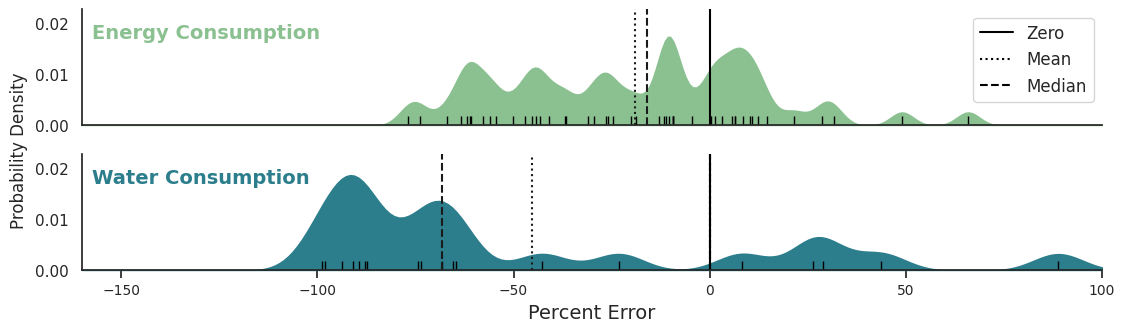

In [ ]:
#reformat validation dataframe to work with facetgrid
kde_plt = validation_set
kde_plt['Energy Consumption'] = 'Energy Consumption'
kde_plt['Water Consumption'] = 'Water Consumption'
energy = kde_plt[['Energy Consumption', 'Percent Error in Energy Consumption']].rename(columns={'Energy Consumption':'Estimate','Percent Error in Energy Consumption':'Percent Error'})
water = kde_plt[['Water Consumption','Percent Error in Water Consumption']].rename(columns={'Water Consumption':'Estimate','Percent Error in Water Consumption':'Percent Error'})
cat_plt = pd.concat([energy, water])

#create ridgeline plots for model energy and water estimation accuracy
plt.figure(figsize=(6, 10))
sns.set_theme(style='white')

#initialize the FacetGrid object and custom color palette
pal = sns.blend_palette([sns.color_palette("crest", n_colors=10)[0], sns.color_palette("crest", n_colors=10)[5]], n_colors=2)
g = sns.FacetGrid(cat_plt, row = 'Estimate', hue = 'Estimate', aspect = 8, height = 1.5, palette = pal)

#draw the KDEs and rugplots
g.map(sns.kdeplot, 'Percent Error', bw_adjust = .2, clip_on = True, fill = True, alpha = 1, linewidth = 0)
g.map(sns.rugplot, 'Percent Error', color = 'black', height = 0.08, lw = .1)
g.map(sns.kdeplot, 'Percent Error', clip_on = False, color = 'w', lw = 0, bw_adjust = .2)
g.refline(y = 0, linewidth = 1, linestyle = "-", color = None, clip_on = False)

#set the subplots to not overlap
g.figure.subplots_adjust(hspace = 0.25)

#remove y-axis and tick marks
g.despine(bottom = False, left = False)
g.fig.text(0.04, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 12)

#label each subplot with corresponding parameter
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .8, label, fontweight = 'bold', color = color,
            ha = 'left', va = 'center', transform = ax.transAxes, fontsize = 14)
    g.set(ylabel = "")
    g.set_titles("")

g.map(label, 'Percent Error')

#add dashed and dotted mean and median lines to each subplot
def mean_med_lines(x, **kwargs):
    plt.axvline(x.mean(), c = 'k', ls = ':', lw = 1.5)
    plt.axvline(x.median(), c = 'k', ls = 'dashed', lw = 1.5)

g.map(mean_med_lines,'Percent Error')

#add vertical black line at % Error = 0
zero = g.axes.flat[0].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[1].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')

#set x-axis limits to exclude outliers
g.set(xlim = (-160, 100))

#format x-axis
plt.setp(plt.gca().get_xticklabels(), fontsize = 10)
plt.xlabel('Percent Error', fontsize = 14)
g.axes.flat[0].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[1].tick_params(axis = 'x', which = 'both', bottom = True, top = False, labelbottom = True)

#add legend and y-axis label
g.axes.flat[0].legend([zero, plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = ':'),plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = 'dashed')], ['Zero', 'Mean', 'Median'], fontsize = 12)
g.figure.subplots_adjust(left=0.1, right=0.95, top=0.97, bottom=0.1, hspace=0.25)

#export figure to jpg
plt.savefig(file_path + '/results/figure_2.jpeg', format = 'jpeg')

plt.show()

In [ ]:
validation_set.loc[validation_set['Percent Error in Energy Consumption'] > 0]#.shape[0]#/validation_set.shape[0]

,Closest Modeled Location,Facility Type,Technology Level,Tiers,Crop,Growing Season,Footprint (square meters),Growing Area (square meters),Water Use (L/year),Energy Use (MWh/year),Climate Zone,Modeled Energy Consumption (MWh/year),Modeled Water Consumption (L/year),Error in Energy Consumption,Error in Water Consumption,Percent Error in Energy Consumption,Percent Error in Water Consumption,Energy Consumption,Water Consumption
5,"Phoenix, Arizona",Greenhouse,High-tech,NaN,Lettuce,Full year,1871.000000,1701.9000,NaN,434.900000,Hot-Dry,721.497593,2.376050e+06,286.597593,NaN,65.899653,NaN,Energy Consumption,Water Consumption
6,"Phoenix, Arizona",Greenhouse,High-tech,NaN,Lettuce,Full year,1871.000000,1701.9000,NaN,548.400000,Hot-Dry,721.497593,2.376050e+06,173.097593,NaN,31.564112,NaN,Energy Consumption,Water Consumption
7,"St. Paul, Minnesota",Plant Factory,High-tech,1.0,Lettuce,Full year,1871.000000,1361.5200,NaN,945.500000,Cold,1217.181509,1.133905e+05,271.681509,NaN,28.734163,NaN,Energy Consumption,Water Consumption
8,"Seattle, Washington",Plant Factory,High-tech,1.0,Lettuce,Full year,1871.000000,1361.5200,NaN,926.600000,Marine,979.438308,1.291003e+05,52.838308,NaN,5.702386,NaN,Energy Consumption,Water Consumption
9,"Phoenix, Arizona",Plant Factory,High-tech,1.0,Lettuce,Full year,1871.000000,1361.5200,NaN,964.400000,Hot-Dry,1046.900729,1.157698e+05,82.500729,NaN,8.554617,NaN,Energy Consumption,Water Consumption
11,"Phoenix, Arizona",Plant Factory,High-tech,1.0,Lettuce,Full year,1871.000000,1361.5200,NaN,983.000000,Hot-Dry,1046.900729,1.157698e+05,63.900729,NaN,6.500583,NaN,Energy Consumption,Water Consumption
12,"Phoenix, Arizona",Plant Factory,High-tech,1.0,Lettuce,Full year,1871.000000,1361.5200,NaN,983.000000,Hot-Dry,1046.900729,1.157698e+05,63.900729,NaN,6.500583,NaN,Energy Consumption,Water Consumption
20,"Seattle, Washington",Greenhouse,Low-tech (+boiler),NaN,Lettuce,Full year,12195.121950,10000.0000,6000000.0,3055.555556,Marine,3063.838752,4.611254e+06,8.283196,-1.388746e+06,0.271086,-23.145772,Energy Consumption,Water Consumption
21,"St. Paul, Minnesota",Plant Factory,High-tech,5.0,Lettuce,Full year,16666.666670,50000.0000,4000000.0,32407.407410,Cold,36420.793080,5.050351e+06,4013.385670,1.050351e+06,12.384161,26.258778,Energy Consumption,Water Consumption
22,"Seattle, Washington",Plant Factory,High-tech,5.0,Lettuce,Full year,16666.666670,50000.0000,4000000.0,32407.407410,Marine,35895.806381,5.750057e+06,3488.398971,1.750057e+06,10.764203,43.751430,Energy Consumption,Water Consumption


In [ ]:
#analyze accuracy based on facility type
validation_set[['Facility Type', 'Percent Error in Energy Consumption','Percent Error in Water Consumption']].groupby('Facility Type').mean()

,Percent Error in Energy Consumption,Percent Error in Water Consumption
Facility Type,,
Greenhouse,-21.081684,-45.024337
Plant Factory,-17.318532,-45.855187


In [ ]:
#analyze accuracy based on climate zone
validation_set[['Climate Zone', 'Percent Error in Energy Consumption','Percent Error in Water Consumption']].groupby('Climate Zone').mean()

,Percent Error in Energy Consumption,Percent Error in Water Consumption
Climate Zone,,
Cold,-30.232812,-64.989858
Hot-Dry,0.091988,58.887130
Hot-Humid,-10.569329,NaN
Marine,-8.880809,-28.054123
Mixed-Humid,-53.225006,-87.788683
Very Cold,-34.546177,NaN


In [ ]:
#analyze accuracy based on crop
validation_set[['Crop', 'Percent Error in Energy Consumption','Percent Error in Water Consumption']].groupby('Crop').mean()

,Percent Error in Energy Consumption,Percent Error in Water Consumption
Crop,,
Basil,-76.913357,-98.794709
Lettuce,-16.681440,-28.913289
Tomato,-29.069103,-77.488347


In [ ]:
#analyze water estimate accuracy for empirical versus modeled data
print('MPE for modeled data: ' + str(validation_set.iloc[0:39]['Percent Error in Water Consumption'].mean()))
print('MPE for empirical data: ' + str(validation_set.iloc[39:50]['Percent Error in Water Consumption'].mean()))

MPE for modeled data: -12.164460450119805
MPE for empirical data: -82.27384453393502


#Calculate water-energy-carbon footprint for portfolio of facilities across the United States

In [ ]:
#create dataframe to hold annual energy + water footprint of CEA facilities
annual_footprint = pd.DataFrame()
annual_footprint['Location'] = np.nan
annual_footprint['State'] = np.nan
annual_footprint['Facility Type'] = np.nan
annual_footprint['Facility Size'] = np.nan
annual_footprint['Technology Level'] = np.nan
annual_footprint['Crop'] = np.nan
annual_footprint['Electricity Required for LEDs (MWh/year)'] = np.nan
annual_footprint['Energy Required for Heating (MWh/year)'] = np.nan
annual_footprint['Energy Required for Cooling (MWh/year)'] = np.nan
annual_footprint['Energy Required for Ventilation (MWh/year)'] = np.nan
annual_footprint['Evapotranspiration (L/year)'] = np.nan
annual_footprint['Annual Water Consumption (L/year)'] = np.nan

#upload dataframe with locations to be modeled for site feasibility tool
locations = pd.read_csv(file_path + '/raw_data/modeled_locations.csv')

#for 73 cities distributed throughout the United States, calculate the annual energy use and water use
for index, row in locations.iterrows():
  location = row['Location'] #location of CEA facility
  lat = row['Latitude'] #latitude corresponding to location
  state = row['State'] #state of location
  climate_zone = row['Climate Zone'] #climate zone of location

  #process meteorological data for selected location
  try:
    monthly_met = clean_met_data(location)
  except:
    print(location)

  #calculate average daily temperature / sunlight statistics for selected location
  monthly_sun = calc_sun(lat, location, monthly_met)

  #iterate through facility types
  for facility_type in ['Hoop House','Greenhouse','Plant Factory']:
    #iterate through facility sizes
    for facility_size in ['Small','Medium','Large']:
      #iterate through technology levels
      for tech_level in ['Low-tech','High-tech']:
        if (((tech_level == 'Low-tech') & (facility_type == 'Plant Factory')) == False):
          #iterate through crops
          for crop in ['Roses', 'Lettuce', 'Spinach', 'Broccoli', 'Basil', 'Tomatoes', 'Cucumbers', 'Bell peppers', 'Zucchini','Strawberries']:
            #create dataframe to hold monthly lighting/temperature control power requirements and water loss due to evapotranspiration
            monthly_footprint = pd.DataFrame()
            monthly_footprint['Month'] = range(1,13)
            monthly_footprint['Electricity Required for LEDs (MWh/month)'] = np.nan
            monthly_footprint['Energy Required for Heating and Cooling (MWh/month)'] = np.nan
            monthly_footprint['Evapotranspiration (kg/month)'] = np.nan

            #create a dictionary with days for each month in the year
            days_per_month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

            #iterate through months of the year
            for index, row in monthly_footprint.iterrows():
              month = row['Month']

              #assign static variables based on crop, facility size, facility type, and technology level
              basic_setup(crop, facility_size, facility_type, tech_level, month)

              #for each hour the day in given month, calculate lighting/temperature control power requirements and water loss due to evapotranspiration
              hourly_LED = calc_LED(monthly_sun)
              hourly_ET = calc_ET(hourly_LED, monthly_sun)
              hourly_hc = calc_heating_cooling(monthly_sun, hourly_ET, hourly_LED)

              #sum hourly power/water requirements to monthly requirements
              monthly_footprint.at[index, 'Electricity Required for LEDs (MWh/month)'] = hourly_LED['Total LED Electricity'].sum() * growing_area / 1000000 * days_per_month[month]
              monthly_footprint.at[index, 'Energy Required for Heating (MWh/month)'] = hourly_hc['Energy for heating'].sum() * days_per_month[month] * 0.001
              monthly_footprint.at[index, 'Energy Required for Cooling (MWh/month)'] = hourly_hc['Energy for cooling'].sum() * days_per_month[month] * 0.001
              monthly_footprint.at[index, 'Evapotranspiration (L/month)'] = hourly_ET['ET'].sum() * growing_area * days_per_month[month]
              monthly_footprint.at[index, 'Energy Required for Ventilation (MWh/month)'] = calc_ventilation(month, tech_level, facility_type, facility_size, hourly_ET) * days_per_month[month]

              #scale up evapotranspiration estimates to total water consumed using ratios from RII: https://resourceinnovation.org/wp-content/uploads/2023/06/RII-Water-BPG-2023.pdf
              if facility_type == 'Hoop House':
                monthly_footprint.at[index, 'Water Consumption (L/month)'] = hourly_ET['ET'].sum() * growing_area * days_per_month[month]
              elif (facility_type == 'Greenhouse') & (tech_level == 'Low-tech'):
                monthly_footprint.at[index, 'Water Consumption (L/month)'] = hourly_ET['ET'].sum() * growing_area * days_per_month[month]
              elif (facility_type == 'Greenhouse') & (tech_level == 'High-tech'):
                monthly_footprint.at[index, 'Water Consumption (L/month)'] = (hourly_ET['ET'].sum() * growing_area * days_per_month[month]) / 0.5
              elif facility_type == 'Plant Factory':
                monthly_footprint.at[index, 'Water Consumption (L/month)'] = (hourly_ET['ET'].sum() * growing_area * days_per_month[month]) / 0.8

            #sum monthly water/power requirements to obtain annual footprint
            annual_footprint.loc[len(annual_footprint)] = {'Location':location, 'State':state, 'Facility Type':facility_type, 'Facility Size':facility_size, 'Technology Level':tech_level, 'Crop':crop, 'Electricity Required for LEDs (MWh/year)':monthly_footprint['Electricity Required for LEDs (MWh/month)'].sum(), 'Energy Required for Heating (MWh/year)':monthly_footprint['Energy Required for Heating (MWh/month)'].sum(), 'Energy Required for Cooling (MWh/year)':monthly_footprint['Energy Required for Cooling (MWh/month)'].sum(), 'Energy Required for Ventilation (MWh/year)':monthly_footprint['Energy Required for Ventilation (MWh/month)'].sum(), 'Evapotranspiration (L/year)':monthly_footprint['Evapotranspiration (L/month)'].sum(),'Annual Water Consumption (L/year)':monthly_footprint['Water Consumption (L/month)'].sum()}

  #print location to show progress
  print(location)

  #export partially complete footprint to .csv file in case session times out
  annual_footprint.to_csv(file_path + '/results/annual_footprint.csv')

Miami, Florida
Lihue, Hawaii
Tampa, Florida
New Orleans, Louisiana
Austin, Texas
Phoenix, Arizona
Uvalde, Texas
Charleston, South Carolina
Montgomery, Alabama
Dallas, Texas
Augusta, Georgia
Columbia, South Carolina
Atlanta, Georgia
Little Rock, Arizona
Oklahoma City, Oklahoma
Midland, Texas
Safford, Arizona
Riverside, California
Modesto, California
San Luis Obispo, California
Salinas, California
Philadelphia, Pennsylvania
Lexington, Kentucky
St. Louis, Missouri


In [ ]:
#add column for total annual energy use
annual_footprint['Annual Energy Consumption (MWh/year)'] = annual_footprint['Electricity Required for LEDs (MWh/year)'] + annual_footprint['Energy Required for Heating (MWh/year)'] + annual_footprint['Energy Required for Cooling (MWh/year)'] + annual_footprint['Energy Required for Ventilation (MWh/year)']

#add columns for electricity use and natural gas use
for index, row in annual_footprint.iterrows():
  #assume that high-tech greenhouses using boilers use natural gas
  if (row['Facility Type'] == 'Greenhouse') & (row['Technology Level'] == 'High-tech'):
    annual_footprint.at[index, 'Annual Electricity Consumption (MWh/year)'] = row['Electricity Required for LEDs (MWh/year)'] + row['Energy Required for Cooling (MWh/year)'] + row['Energy Required for Ventilation (MWh/year)']
    annual_footprint.at[index, 'Annual Natural Gas Consumption (MWh/year)'] = row['Energy Required for Heating (MWh/year)']
  #assume all other facilities are fully electrified
  else:
    annual_footprint.at[index, 'Annual Electricity Consumption (MWh/year)'] = row['Electricity Required for LEDs (MWh/year)'] + row['Energy Required for Heating (MWh/year)'] + row['Energy Required for Cooling (MWh/year)'] + row['Energy Required for Ventilation (MWh/year)']
    annual_footprint.at[index, 'Annual Natural Gas Consumption (MWh/year)'] = 0

#add in latitude/longitude and climate zone columns
annual_footprint = annual_footprint.merge(locations[['Location','Climate Zone','Latitude','Longitude']], how = 'left', on = 'Location')

#convert to geodataframe
annual_footprint = gpd.GeoDataFrame(annual_footprint, geometry = gpd.points_from_xy(annual_footprint.Longitude, annual_footprint.Latitude))

#upload carbon intensity of electricity supply by balancing region from NREL Cambium 2024 Scenario [kg CO2-eq / MWh]; note, does not include AK and HI
elec_CI = pd.read_csv(file_path + '/raw_data/carbon_intensity/Cambium24_allScenarios_annual_balancingArea.csv', header = 5)[['scenario','t','r','aer_load_co2e']]

#filter to midcase scenario
elec_CI = elec_CI.loc[elec_CI['scenario'] == 'MidCase']

#filter to 2025
elec_CI = elec_CI.loc[elec_CI['t'] == 2025].rename(columns = {'r':'rb'})

#import shapefile of balancing areas from NREL scenario viewer
balancing_areas = gpd.read_file(file_path + '/raw_data/balancing_areas/US_PCA.shp')

#change formatting of balancing area names to match 2024 Cambium
balancing_areas.loc[(balancing_areas['rb'] == 'p119') | (balancing_areas['rb'] == 'p122'), 'rb'] = 'p122'
balancing_areas.loc[balancing_areas['rb'] == 'p122', 'rb'] = 'z122'

#for each balancing area, merge polygons into one
balancing_areas = balancing_areas.dissolve(by = 'rb')
balancing_areas.reset_index(inplace = True)

#merge carbon intensity of electricity supply with balancing area shapefile
elec_CI_gdf = gpd.GeoDataFrame(elec_CI.merge(balancing_areas[['rb','geometry']], how = 'left', on = 'rb'), geometry = 'geometry')

#for each city in portfolio, identify what balancing area it is in and associated carbon intensity of electricity supply
annual_footprint = gpd.sjoin(annual_footprint, elec_CI_gdf, how="left", predicate="within")

#upload state-level averages of grid carbon intensity from EIA [kg CO2/million BTU] for AK and HI
AK_HI_elec_CI = pd.read_excel(file_path + '/raw_data/carbon_intensity/state_level_carbon_intensity.xlsx', sheet_name = 'Table 6', header = 4)

#filter to 2022 AK and HI carbon intensity of energy supply
AK_HI_elec_CI = AK_HI_elec_CI[['State', 2022]]
AK_HI_elec_CI[2022] = AK_HI_elec_CI[2022] / 0.293071
AK_HI_elec_CI.rename(columns = {2022:'2022 Carbon Intensity (kg CO2-eq/MWh)'}, inplace = True)
AK_HI_elec_CI = AK_HI_elec_CI.loc[(AK_HI_elec_CI['State'] == 'Alaska') | (AK_HI_elec_CI['State'] == 'Hawaii')]

#for cities in AK and HI, use carbon intensity of electricity supply from EIA
annual_footprint.loc[annual_footprint['State'] == 'Alaska', 'aer_load_co2e'] = AK_HI_elec_CI.loc[AK_HI_elec_CI['State'] == 'Alaska', '2022 Carbon Intensity (kg CO2-eq/MWh)'].values[0]
annual_footprint.loc[annual_footprint['State'] == 'Hawaii', 'aer_load_co2e'] = AK_HI_elec_CI.loc[AK_HI_elec_CI['State'] == 'Hawaii', '2022 Carbon Intensity (kg CO2-eq/MWh)'].values[0]

#add column for CO2 emissions from electricity usage
annual_footprint['Annual CO2 emissions (Electricity) (kg CO2-eq/year)'] = annual_footprint['Annual Electricity Consumption (MWh/year)'] * annual_footprint['aer_load_co2e']

#add column for CO2 emissions from natural gas usage; carbon intensity of natural gas from https://www.eia.gov/environment/emissions/co2_vol_mass.php
annual_footprint['Annual CO2 emissions (Natural Gas) (kg CO2-eq/year)'] = annual_footprint['Annual Natural Gas Consumption (MWh/year)'] * (3.412 * 10**6) / (10**6) * 75.09

#add column for total CO2 emissions
annual_footprint['Annual CO2 Emissions (kg CO2-eq/year)'] = annual_footprint['Annual CO2 emissions (Electricity) (kg CO2-eq/year)'] + annual_footprint['Annual CO2 emissions (Natural Gas) (kg CO2-eq/year)']

#export final dataframe to .csv file
annual_footprint[['Location','Latitude','Longitude','Facility Type','Facility Size','Technology Level','Crop','Evapotranspiration (L/year)','Annual Water Consumption (L/year)','Annual Energy Consumption (MWh/year)','Annual CO2 Emissions (kg CO2-eq/year)']].to_csv(file_path + '/results/annual_footprint.csv')